# 테서랙트 써보기

### 1. 테서랙트 설치

$ sudo apt install tesseract-ocr   

$ sudo apt install libtesseract-dev

### 2. 테서랙트 파이썬 wrapper 설치하기

Pytesseract는 OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수있도록 해주는 래퍼 라이브러리(wrapper library)입니다. 파이썬 내에서 컴퓨터에 설치된 테서랙트 엔진의 기능을 바로 쓸 수 있도록 해줍니다.   
pip install pytesseract

### 3. 테서랙트로 문자 검출하고 이미지 자르기 (detection)

In [1]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/test.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/home/aiffel0042/aiffel/ocr_python/0000.png
/home/aiffel0042/aiffel/ocr_python/0001.png
/home/aiffel0042/aiffel/ocr_python/0002.png
/home/aiffel0042/aiffel/ocr_python/0003.png
/home/aiffel0042/aiffel/ocr_python/0004.png
/home/aiffel0042/aiffel/ocr_python/0005.png
/home/aiffel0042/aiffel/ocr_python/0006.png
/home/aiffel0042/aiffel/ocr_python/0007.png
/home/aiffel0042/aiffel/ocr_python/0008.png
/home/aiffel0042/aiffel/ocr_python/0009.png
/home/aiffel0042/aiffel/ocr_python/0010.png


위에서 구현한 crop_word_regions() 함수는 여러분이 선택한 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수입니다.

기본적으로 pytesseract.image_to_data() 를 사용합니다. 파이썬에서 편하게 사용하기 위해서 pytesseract 의 Output 을 사용해서 결과값의 형식을 딕셔너리(DICT) 형식으로 설정해주게 됩니다. 이렇게 인식된 결과는 바운딩 박스의 left, top, width, height 정보를 가지게 됩니다. 바운딩 박스를 사용해 이미지의 문자 영역들을 파이썬 PIL(pillow) 또는 opencv 라이브러리를 사용해 잘라(crop)서 cropped_image_path_list에 담아 리턴하였습니다.

(주의) 위 코드에서 lang='kor' 로 바꾸면 에러가 발생합니다. 테서랙트의 언어팩을 설치해야 정상동작하게 됩니다.   
$sudo apt install tesseract-ocr-kor

### 4. 테서랙트로 잘린 이미지에서 단어 인식하기

In [2]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

HOME

tj

ae

Hilal eae

.

Bite ia,

Pe ie ey

HOS

+L ULB ADRINK Se


5 %

Done


# keras-ocr 써보기

위에서 구글 API를 쓰듯이 OCR을 데모로 써볼 수 있지만 직접 OCR 모델을 만들어 돌려보고 싶을 때는 어떻게 해야 할까요? 저희는 텐서플로우 기반의 모델을 주로 다뤄왔으니 텐서플로우를 기반으로 모델을 구현해서 OCR을 직접 돌려보도록 하겠습니다.

keras-ocr은 텐서플로우의 케라스 API를 기반으로 이미지 속 문자를 읽는 End-to-End OCR을 할 수 있게 해줍니다. 공식 문서에도 나와 있듯, 검출 모델로는 네이버 데뷰 2018 영상에서 소개한 CRAFT(Character Region Awareness for Text Detection)를 사용하고, 인식 모델로는 앞에서 설명한 CRNN을 사용합니다.   
$ pip install keras-ocr

필요한 라이브러리인 keras_ocr 과 인식결과의 시각화를 위한 matplotlib.pyplot 를 불러옵니다. keras_ocr.pipeline.Pipeline() 는 인식을 위한 파이프라인을 생성하는데 이때 초기화 과정에서 미리 학습된 모델의 가중치(weight)를 불러오게 됩니다. 검출기와 인식기를 위한 가중치 하나씩을 불러오겠지요.

확인을 위해서 터미널을 열어 다음과 같이 확인해 보시기 바랍니다. true가 출력되어야 환경설정에 반영되어 있는 것입니다. 만약 이 환경설정이 반영되어 있지 않으면 이후 코드 구동 과정에서 OOM(Out Of Memory) 에러가 날 수 있습니다.

$ echo $TF_FORCE_GPU_ALLOW_GROWTH

In [5]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel0042/.keras-ocr/craft_mlt_25k.h5
Looking for /home/aiffel0042/.keras-ocr/crnn_kurapan.h5


만들어둔 파이프라인의 recognize() 에 이미지를 몇 가지 넣어줍니다. 예시의 편의 상 url을 읽어 요청하겠습니다.



In [6]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
        'https://upload.wikimedia.org/wikipedia/commons/b/bd/Army_Reserves_Recruitment_Banner_MOD_45156284.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/e/e8/FseeG2QeLXo.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/b/b4/EUBanana-500x112.jpg'
    ]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

이제 인식된 결과를 pyplot으로 시각화를 해봅니다.

사용이 매우 간단합니다! 내부적으로 recognize() 는 검출기와 인식기를 두고, 검출기로 바운딩 박스(bounding box, 문자가 있는 영역을 표시한 정보)를 검출한 뒤, 인식기가 각 박스로부터 문자를 인식하는 과정을 거치도록 합니다.

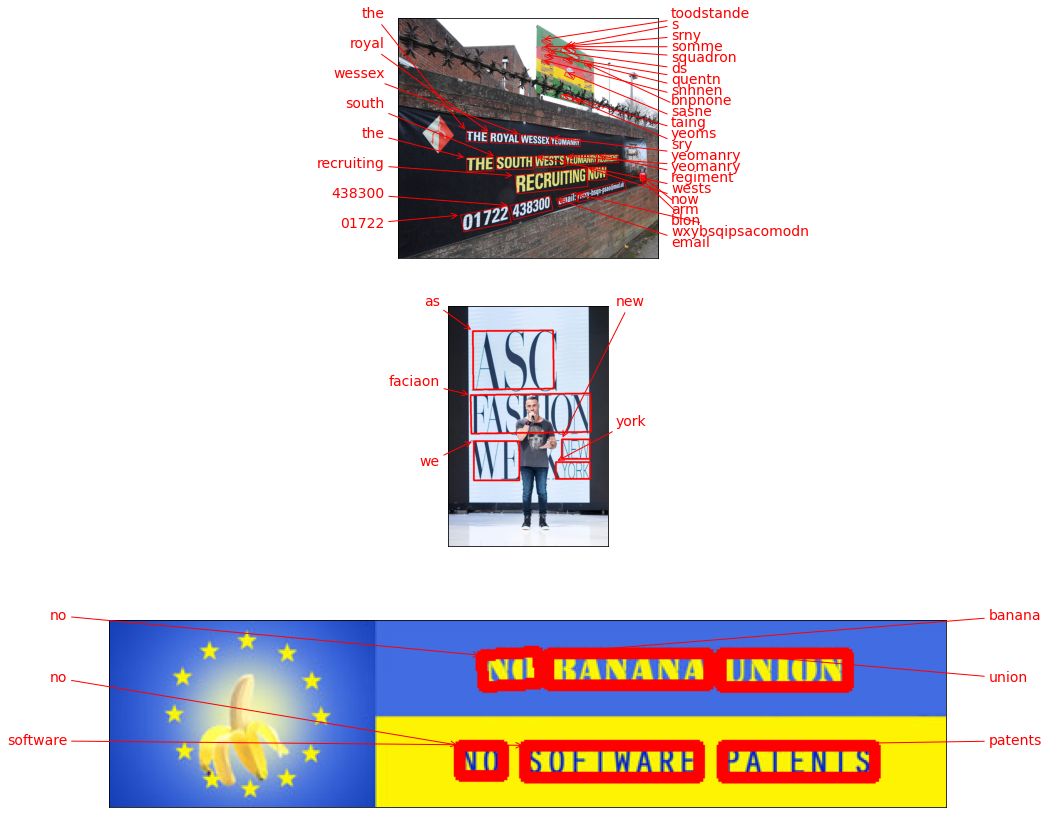

In [7]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(15,15))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

keras-ocr은 한글 데이터셋으로 훈련이 되어있지 않은 모델입니다. 한글 텍스트의 detection은 정상적으로 진행되더라도 recognition 결과가 엉뚱하게 나올 수 있음에 주의해 주세요.